# Семинар 1: знакомство с PyTorch 🔥

## Вступление

В этом семинаре мы познакомимся с библиотекой **PyTorch**. Он очень похож на **NumPy**, с одним лишь отличием (на самом деле их больше, но сейчас мы поговорим про самое главное) — **PyTorch** может считать градиенты за вас. Таким образом вам не надо будет руками писать обратный проход в нейросетях.

**План семинара**

1. Вспоминаем **NumPy** и сравниваем операции его функциональность с **PyTorch**
2. Создаем тензоры в **PyTorch** и изучаем больше базовых операций
3. Работаем с градиентами руками
4. Моя первая нейросеть

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm.notebook import tqdm

# %matplotlib inline

### 1. Вспоминаем **NumPy** и сравниваем операции его функциональность с **PyTorch**

Мы можем создавать матрицы, перемножать их, складывать, транспонировать и в целом совершать любые матричные операции

In [2]:
# случайная матрица
a = np.random.rand(5, 3)
a

array([[0.90412031, 0.36822362, 0.44017022],
       [0.52003951, 0.67530445, 0.88746073],
       [0.7710356 , 0.65839013, 0.24088424],
       [0.95864898, 0.69819109, 0.31496713],
       [0.80286028, 0.45212203, 0.05919728]])

In [3]:
# размеры массива
a.shape

(5, 3)

In [4]:
# сложение
a + 5

array([[5.90412031, 5.36822362, 5.44017022],
       [5.52003951, 5.67530445, 5.88746073],
       [5.7710356 , 5.65839013, 5.24088424],
       [5.95864898, 5.69819109, 5.31496713],
       [5.80286028, 5.45212203, 5.05919728]])

In [5]:
# матричное умножение
a @ a.T

array([[1.14677199, 1.10947512, 1.04557381, 1.26246362, 0.91842118],
       [1.10947512, 1.51406374, 1.05935806, 1.24954786, 0.77537434],
       [1.04557381, 1.05935806, 1.08599868, 1.27470524, 0.93096623],
       [1.26246362, 1.24954786, 1.27470524, 1.50568297, 1.10397396],
       [0.91842118, 0.77537434, 0.93096623, 1.10397396, 0.85250328]])

In [6]:
# среднее по колонкам
a.mean(axis=-1)

array([0.57083805, 0.69426823, 0.55676999, 0.65726907, 0.43805986])

In [7]:
# решейп
a.reshape(3, 5).shape

(3, 5)

**Разминка**

При помощи **NumPy** посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [9]:
(np.arange(10001) ** 2).sum()

333383335000

Аналогичные операции в **PyTorch** очень похожи, но иногда имеют немного другой синтаксис

In [10]:
# случайный тензор
x = torch.rand(5, 3)
x

tensor([[0.5779, 0.2912, 0.2381],
        [0.7219, 0.4937, 0.9704],
        [0.2860, 0.8364, 0.1471],
        [0.0670, 0.4194, 0.7119],
        [0.8010, 0.6215, 0.7224]])

In [11]:
# размеры тензора
x.shape

torch.Size([5, 3])

In [12]:
# тоже размеры тензора
x.size()

torch.Size([5, 3])

In [13]:
# сложение
x + 5

tensor([[5.5779, 5.2912, 5.2381],
        [5.7219, 5.4937, 5.9704],
        [5.2860, 5.8364, 5.1471],
        [5.0670, 5.4194, 5.7119],
        [5.8010, 5.6215, 5.7224]])

In [14]:
# матричное умножение
# читайте документации по различным вариантам: @, torch.mm, torch.matmul, torch.bmm
torch.matmul(x, x.transpose(1, 0))

tensor([[0.4755, 0.7920, 0.4439, 0.3304, 0.8159],
        [0.7920, 1.7066, 0.7621, 0.9463, 1.5861],
        [0.4439, 0.7621, 0.8030, 0.4746, 0.8551],
        [0.3304, 0.9463, 0.4746, 0.6872, 0.8286],
        [0.8159, 1.5861, 0.8551, 0.8286, 1.5497]])

In [15]:
# очередное матричное умножение
x.mm(x.t())

tensor([[0.4755, 0.7920, 0.4439, 0.3304, 0.8159],
        [0.7920, 1.7066, 0.7621, 0.9463, 1.5861],
        [0.4439, 0.7621, 0.8030, 0.4746, 0.8551],
        [0.3304, 0.9463, 0.4746, 0.6872, 0.8286],
        [0.8159, 1.5861, 0.8551, 0.8286, 1.5497]])

In [ ]:
# поэлементное умножение
x * x

In [16]:
# среднее по колонкам
x.mean(dim=-1)

tensor([0.3691, 0.7287, 0.4232, 0.3994, 0.7150])

In [17]:
# решейп
x.view([3, 5]).shape

torch.Size([3, 5])

In [18]:
# или так
x.reshape([3, 5]).shape

torch.Size([3, 5])

In [20]:
# будьте внимательны и не используйте view для транспонирования осей!
x.view([3, 5]) == x.t()

tensor([[ True, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True]])

Небольшой пример того, как меняются операции:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype("int64") -> x.type(torch.LongTensor)`

Для помощи вам есть [таблица](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users), которая поможет вам найти аналог **NumPy** операции в **PyTorch**


Разминка на PyTorch

При помощи pytorch посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [21]:
(torch.arange(10001) ** 2).sum()

tensor(333383335000)

### 2. Создаем тензоры в **PyTorch** и изучаем больше базовых операций

In [22]:
# пустой тензор
x = torch.empty(5, 3)
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [23]:
# случайный тензор ~ Uniform[0, 1)
x = torch.rand(5, 3)
x

tensor([[0.6016, 0.2104, 0.0558],
        [0.4391, 0.6185, 0.3382],
        [0.0333, 0.5988, 0.9822],
        [0.7088, 0.9519, 0.4159],
        [0.7283, 0.3936, 0.0128]])

In [24]:
# тензор с нулями и указанием типов чисел
x = torch.zeros(5, 3, dtype=torch.float32)
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [25]:
# конструируем тензор из питоновского листа
x = torch.tensor([5.5, 3])
x

tensor([5.5000, 3.0000])

In [26]:
# используем уже созданный тензор для создания тензора из единичек
# по умолчанию: используем dtype и device тензора, для которого применяем
# метод new_ones
x1 = x.new_ones(5, 3, dtype=torch.double)
x1

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

In [27]:
# создаем случайный тензор с размерами другого тензора
x = torch.randn_like(x1, dtype=torch.float)
x

tensor([[-1.1639, -1.0015, -0.7630],
        [ 0.1256, -1.9478,  0.1150],
        [-0.1867, -1.8740,  0.0255],
        [ 0.1697, -0.3189, -0.9322],
        [-0.1572, -1.2664, -0.7510]])

In [28]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)

In [29]:
x

tensor([[0.2532, 0.8683, 0.4527],
        [0.8645, 0.7054, 0.5457],
        [0.0685, 0.6299, 0.0420],
        [0.7823, 0.6895, 0.8782],
        [0.2626, 0.6215, 0.8222]])

In [30]:
y

tensor([[0.6418, 0.7371, 0.1249],
        [0.3679, 0.8428, 0.1260],
        [0.8203, 0.5760, 0.7474],
        [0.8711, 0.8588, 0.8699],
        [0.0482, 0.3351, 0.0410]])

In [33]:
# сложение
x + y

tensor([[0.8950, 1.6054, 0.5776],
        [1.2324, 1.5482, 0.6717],
        [0.8888, 1.2059, 0.7894],
        [1.6534, 1.5482, 1.7481],
        [0.3108, 0.9566, 0.8633]])

In [34]:
# очередное сложение
z = torch.add(x, y)
z

tensor([[0.8950, 1.6054, 0.5776],
        [1.2324, 1.5482, 0.6717],
        [0.8888, 1.2059, 0.7894],
        [1.6534, 1.5482, 1.7481],
        [0.3108, 0.9566, 0.8633]])

In [35]:
# наконец, ещё одно сложение!
torch.add(x, y, out=x)
x

tensor([[0.8950, 1.6054, 0.5776],
        [1.2324, 1.5482, 0.6717],
        [0.8888, 1.2059, 0.7894],
        [1.6534, 1.5482, 1.7481],
        [0.3108, 0.9566, 0.8633]])

In [36]:
x.size()

torch.Size([5, 3])

In [37]:
# добавили измерение в начало, аналог броадкастинга
x.unsqueeze(0).size()

torch.Size([1, 5, 3])

In [38]:
# убрали одно единичное измерение

  # (1, 5, 3)  # (1, 1, 5, 3)     # (1, 5, 3)
x.unsqueeze(0).unsqueeze(1).squeeze(0).size()

torch.Size([1, 5, 3])

In [39]:
# убрали все единичные измерения
x.unsqueeze(0).unsqueeze(1).squeeze().size()

torch.Size([5, 3])

In [40]:
# операции без _ не меняют тензор, а создают копию
x.unsqueeze(0)
x.size()

torch.Size([5, 3])

In [41]:
# операции с _ меняют тензор
x.unsqueeze_(0)
x.size()

torch.Size([1, 5, 3])

Мы можем делать обычные срезы и переводить матрицы из **PyTorch** в **NumPy** и наоборот:

In [42]:
a = np.ones((3, 5))
x = torch.ones((3, 5))
np.allclose(x.numpy(), a)

True

In [43]:
np.allclose(x.numpy()[:, 1], a[:, 1])

True

In [44]:
torch.from_numpy(x.numpy())

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

### 3. Работаем с градиентами руками

In [45]:
# скачиваем The Boston Housing Dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

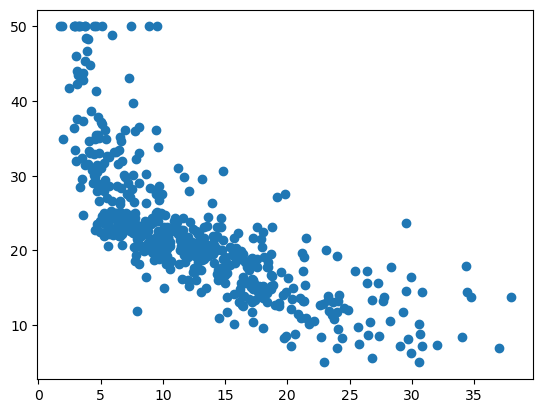

In [46]:
plt.scatter(data[:, -1], target);

В **PyTorch** есть возможность при создании тензора указывать нужно ли считать по нему градиент или нет, с помощью параметра `requires_grad`. Когда `requires_grad=True` мы сообщаем фреймворку, о том, что мы хотим следить за всеми тензорами, которые получаются из созданного. Иными словами, у любого тензора, у которого указан данный параметр, будет доступ к цепочке операций и преобразований совершенными с ними. Если эти функции дифференцируемые, то у тензора появляется параметр `.grad`, в котором хранится значение градиента.

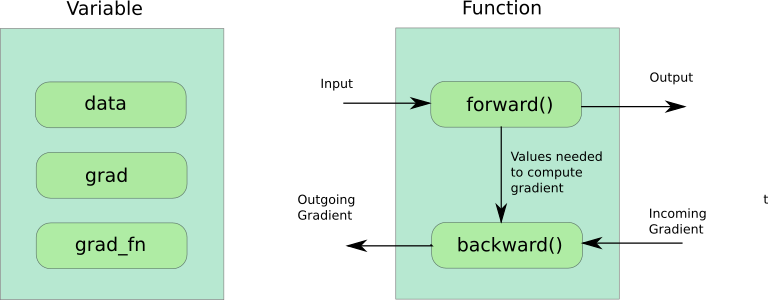

Если к результирующему тензору применить метод `.backward()`, то фреймворк посчитает по цепочке градиенты для всех тензоров, у которых `requires_grad=True`.

In [47]:
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(data[:, -1] / data[:, -1].max(), dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32)

# только создали тензоры и в них нет градиентов
assert w.grad is None
assert b.grad is None

In [50]:
x.size(), y.size()

(torch.Size([506]), torch.Size([506]))

In [51]:
y_pred = w * x + b
loss = torch.mean((y_pred - y) ** 2)
loss.backward()

In [52]:
# сделали операции и посчитали градиенты, появилось значение соответствующих полей
assert w.grad is not None
assert b.grad is not None

print(f"dL/dw = {w.grad}")
print(f"dL/db = {b.grad}")

dL/dw = tensor([-11.6591])
dL/db = tensor([-42.8063])


Напишем градиентный спуск:

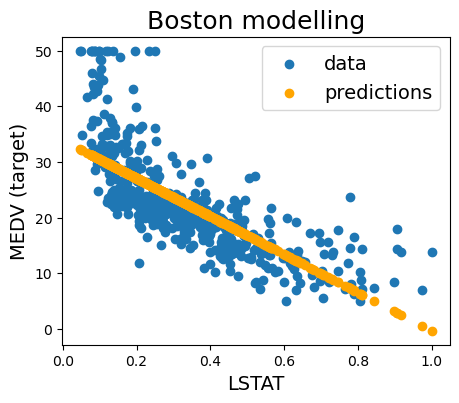

loss =  38.601673


In [54]:
from IPython.display import clear_output
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

for i in range(1000):
    y_pred = w * x + b
    # попробуйте сделать полиномиальную регрессию в данном предсказании и посчитать градиенты после
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()  # => получили производные по w и по b

    # делаем шаг градиентного спуска с lr = .05
    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
    w.grad.data.zero_()
    b.grad.data.zero_()

    # рисуем картинки
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(5, 4))
        plt.scatter(x.data.numpy(), y.data.numpy(), label="data")
        plt.scatter(
            x.data.numpy(),
            y_pred.data.numpy(),
            color="orange",
            # linewidth=5,
            label="predictions",
        )
        plt.xlabel("LSTAT", fontsize=14)
        plt.ylabel("MEDV (target)", fontsize=14)
        plt.title("Boston modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.1:
            print("Done!")
            break

### 4. Моя первая нейросеть

Для того, чтобы разобраться как обучать нейросети в **PyTorch**, нужно освоить три вещи:

1. Как формировать батчи и подавать их на вход сети
2. Как задать архитектуру сети
3. Как написать цикл обучения и отслеживать метрики

#### Как формировать батчи и подавать их на вход нейросети

Чтобы иметь возможность итерироваться по данным и применять к ним преобразования (например, аугментации, о которых вы узнаете позже), нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

У такого класса **должно быть** три метода:

* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` — возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` — по индексу возвращает семпл и таргет к нему


Давайте напишем такой сами, в качестве данных используя рандомные значения.

In [60]:
from torch.utils.data import Dataset

class RandomDataset(Dataset):
    """
    Our random dataset
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [56]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [61]:
our_dataset = RandomDataset(x, y)
len(our_dataset)

1000

In [62]:
# our_dataset.__getitem__(1)
our_dataset[1]

{'sample': tensor([0.7372, 0.7321, 0.9366, 0.4413, 0.1656]),
 'target': 0.19502736576936142}

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как даталоадер, который принимает на вход класс унаследованный от `torch.utils.data.Dataset`. Сейчас посмотрим на пример:

In [63]:
from torch.utils.data import DataLoader
dataloader = DataLoader(our_dataset, batch_size=4)

Работают с ним следующим образом:

In [64]:
# batch = next(iter(dataloader))
for batch in dataloader:
    break

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[0.3859, 0.5995, 0.1126, 0.2727, 0.9476],
        [0.7372, 0.7321, 0.9366, 0.4413, 0.1656],
        [0.7764, 0.2719, 0.2380, 0.5785, 0.9300],
        [0.9788, 0.4057, 0.4346, 0.0089, 0.2947]])
Target:
tensor([0.2113, 0.1950, 0.0028, 0.1094], dtype=torch.float64)


**Как сделать нейросеть**

# На это пока забиваем

Для того, чтобы в high-level **PyTorch** создавать нейросети, используется модуль `torch.nn`. Нейросеть должна быть унаследована от класса `nn.Module`. Пример как это может выглядеть:

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

Как мы видим на данном примере, у данного класса **должен быть** метод `forward`, который определяет прямой проход нейросети. Также из класса выше видно, что модуль `nn` содержит в себе реализацию большинства слоев, а модуль `nn.functional` -- функций активаций.

Есть еще один способ создать нейросеть и давайте его разберем на практике:

In [66]:
# на это тоже забиваем
# model = nn.Sequential()  # создаем пустую модель, в которую будем добавлять слои
# model.add_module(
#     "l1", nn.Linear(5, 30)
# )  # добавили слой с 5-ю нейронами на вход и 3-мя на выход
# model.add_module("l2", nn.ReLU())  # добавили функцию активации
# model.add_module(
#     "l3", nn.Linear(30, 1)
# )  # добавили слой с 3-мя нейронами на вход и 5-ю на выход

# альтернативный способ
model = nn.Sequential(
    nn.Linear(5, 30),
    nn.ReLU(),       
    nn.Linear(30, 1) 
)

In [67]:
y_pred = model(batch["sample"])  # получили предсказания модели
y_pred

tensor([[-0.1829],
        [-0.1887],
        [-0.2270],
        [-0.1891]], grad_fn=<AddmmBackward0>)

**Как написать цикл обучения и отслеживать метрики**

Давайте теперь соберем теперь загрузку данных, создание модели и обучим на уже созданном для нас датасете MNIST

In [68]:
# используем готовый класс от торча для загрузки данных для тренировки
from torchvision.datasets import MNIST
downlaod = False

mnist_train = MNIST(
    "./mnist/", train=True, download=downlaod, transform=torchvision.transforms.ToTensor()
)
mnist_val = MNIST(
    "./mnist/", train=False, download=downlaod, transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
print(f"{isinstance(mnist_train, Dataset) = }")

train_dataloader = DataLoader(
    mnist_train, batch_size=4, shuffle=True, num_workers=1
)

val_dataloader = DataLoader(
    mnist_val, batch_size=4, shuffle=False, num_workers=1
)

isinstance(mnist_train, Dataset) = True


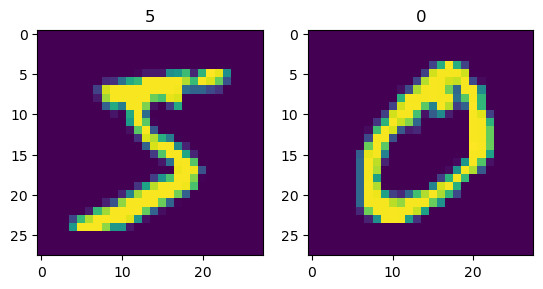

In [69]:
# посмотрим на то, с чем мы работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [70]:
for (x, y) in train_dataloader:
    break

# размер батча, количество каналов (1 -> чб), высота, ширина
(x.shape, y.shape)

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

In [71]:
model = nn.Sequential(
    # превращаем картинку 28х28 в вектор размером 784
    nn.Flatten(),
    # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.Linear(28 * 28, 128),
    # нелинейность
    nn.ReLU(),
    # линейный слой, преобразующий вектор размера 128 в вектор размера 10
    nn.Linear(128, 10)
)

# создаем оптимизатор, который будет обновлять веса модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

Веса моделей хранятся в виде матриц и выглядят так:

In [72]:
[x for x in model.named_parameters()]

[('1.weight',
  Parameter containing:
  tensor([[-5.2066e-03, -3.2032e-02,  3.5058e-02,  ..., -1.0223e-03,
           -9.7703e-05,  2.1064e-02],
          [ 7.7528e-03,  1.1330e-03, -1.6840e-02,  ...,  1.0465e-02,
           -3.0710e-02,  3.4852e-02],
          [ 2.7870e-02,  4.7399e-03,  4.6371e-03,  ..., -1.0030e-02,
            8.4322e-03,  1.8160e-02],
          ...,
          [ 6.9994e-03, -1.2272e-02,  5.6751e-04,  ..., -1.4229e-03,
            6.3320e-03,  8.6744e-03],
          [-6.3672e-03,  1.4709e-02,  3.3615e-02,  ..., -3.2889e-02,
           -5.7794e-03,  1.5083e-02],
          [ 2.5985e-02,  1.2552e-02, -1.1506e-03,  ...,  2.1399e-02,
           -9.1074e-03, -3.3594e-02]], requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([-1.3985e-02, -2.9813e-02, -2.0564e-02,  3.4240e-02, -1.5579e-02,
          -2.4805e-02, -2.1824e-02, -3.2308e-02, -1.7349e-02, -1.9140e-02,
           1.7801e-02, -1.2325e-02, -1.3498e-02, -9.6105e-03,  2.7439e-02,
          -1.7871e-02

Вместо того, чтобы каждый раз самим рисовать графики в `matplotlib`, мы будем _красиво_ трекать метрики в полуавтоматическом режиме в [wandb](https://wandb.ai). Для этого регистрируемся на сайте, устанавливаем и логинимся (это того стоит).

Note. Помимо этого инструмента есть другие альтернативы: Tensorboard (очень минималистичный, работает локально), MLFlow (менее красивый, но опенсорсный), Neptune (примерно как W&B).

In [ ]:
!pip install wandb --upgrade --quiet

In [73]:
import wandb

In [ ]:
# # логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
# !wandb login
# #wandb.login()

In [74]:
# инициализируем проект
wandb.init(project="intro-dl-2023-sem1")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: uasekus. Use `wandb login --relogin` to force relogin


Можно перейти по ссылке и следить за нашей моделью прямо во время обучения!

Одним из основных преимуществ PyTorch является возможность использования GPU-ускорителей на CUDA-совместимых графических процессорах Nvidia Compute Unified Device Architecture (CUDA) и Apple Metal Performance Shaders (MPS). До сих пор все, что мы делали, было на процессоре.

Во-первых, мы должны проверить, доступен ли графический процессор, с помощью метода ```is_available()```. Если у вас не установлен CUDA-совместимый графический процессор и драйверы CUDA, то после исполнения ячейки ниже в качестве девайса будет выступать CPU.

In [75]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device("mps")
else:
    device = torch.device('cpu')

print(device)

mps


Как только мы определили, что один или несколько графических процессоров доступны, нам нужно поместить наши данные туда, где графический процессор сможет их увидеть. Ваш процессор выполняет вычисления над данными в оперативной памяти вашего компьютера. К вашему графическому процессору подключена выделенная память. Всякий раз, когда вы хотите выполнить вычисление на устройстве, вы должны переместить все данные, необходимые для этого вычисления, в память, доступную этому устройству.

По умолчанию новые тензоры создаются на CPU, поэтому нам нужно указать, когда мы хотим создать наш тензор на графическом процессоре, с помощью необязательного аргумента устройства.

In [76]:
x = torch.rand(2, 2, device=device)
x

tensor([[0.3732, 0.0933],
        [0.1341, 0.8828]], device='mps:0')

**Чтобы выполнять вычисления с использованием двух или более тензоров, все тензоры должны находиться на одном устройстве.**

Если у вас уже есть тензор, расположенный на одном устройстве, вы можете переместить его на другое с помощью метода ```to()```.
Перенесем созданную ранее модель на наш новый девайс.

In [77]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [78]:
# всего у нас будет 5 эпох (5 раз подряд пройдемся по всем батчам из трейна)
for epoch in range(5):

    # итерация по трейн-даталоадеру (обучение)
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train.to(device))                       # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train.to(device))       # считаем лосс
        loss.backward()                                          # считаем градиенты обратным проходом
        optimizer.step()                                         # обновляем параметры сети
        optimizer.zero_grad()                                    # обнуляем посчитанные градиенты параметров

    if epoch % 2 == 0:
        val_loss = []                                            # средний по бачу лосс
        val_accuracy = []
        with torch.no_grad():                                    # на валидации не считаем градиенты

            # итерация по val-даталоадеру (валидация)
            for x_val, y_val in tqdm(val_dataloader):
                y_pred = model(x_val.to(device))                 # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val.to(device)) # считаем лосс
                val_loss.append(loss.cpu().numpy())              # добавляем в массив
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val.to(device)).cpu().numpy().tolist()
                )

        # скидываем метрики на wandb и автоматом смотрим на графики
        wandb.log(
            {
                "mean val loss": np.mean(val_loss),
                "mean val accuracy": np.mean(val_accuracy),
            }
        )

        # печатаем метрики
        print(
            f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
        )

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.11602228879928589, accuracy: 0.965


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08694221079349518, accuracy: 0.9747


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.07837790995836258, accuracy: 0.9763


### Дополнительные материалы

* [Хорошая книга про pytorch](https://isip.piconepress.com/courses/temple/ece_4822/resources/books/Deep-Learning-with-PyTorch.pdf)
* [Использование pytorch на GPU](https://pytorch.org/docs/master/notes/cuda.html)
* [Pytorch за 60 минут](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Как устроено автоматическое дифференцирование в pytorch](http://videolectures.net/site/normal_dl/tag=1129745/deeplearning2017_johnson_automatic_differentiation_01.pdf)